# Application of the TadGAN method to temperature signals from the Weather Dataset.

The notebook is based on the Tulog tutorial from the Orion-ML library on GitHub: https://github.com/sintel-dev/Orion/blob/master/tutorials/tulog/Tulog.ipynb.

Data conversion to the Orion format is based on the NASA tutorial from the Orion-ML library on GitHub: https://github.com/sintel-dev/Orion/blob/master/tutorials/Convert_NASA_Data_to_Orion_Format.ipynb.

Basic function was created by the Sintel MIT library. Source: https://github.com/sintel-dev/Orion/tree/master. 

The author of this repository created small preprocessing functions and collected anomaly functions. The 'Utils_weather.py' script was adapted by the author to create plots for this notebook.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils_weather import plot, plot_ts, plot_rws, plot_error, unroll_ts
from data import load_signal, load_anomalies

## Preprocessing

Rename columns of training and test signals and convert the timestamp into TadGAN format.

In [2]:
def renames(dataframe):
    """
    Rename specific columns in a DataFrame.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing columns to be renamed.

    Returns:
        pd.DataFrame: A DataFrame with renamed columns.
    """
    
    new_column_name = {'MESS_DATUM':'timestamp', 'TT_TU':'value'}
    dataframe = dataframe.rename(columns=new_column_name)
    return dataframe

In [3]:
training = 'daily_temperature_training'
test1 = 'daily_temperature_test1'
test2 = 'daily_temperature_test2'

# create dataframes
train_df = pd.read_csv(f'data/{training}.csv')
#train_df = renames(train_df)

#convert data to orion format
train_df['timestamp'] = train_df.index.map(lambda index: index * 86400 + 347151600) #convert data to orion format
train_df = train_df.drop('MESS_DATUM', axis=1)
train_df = train_df.rename(columns={'TT_TU':'value'})
train_df = train_df[['timestamp','value']]
train_df.head(5)


,timestamp,value
0,347151600,1.80
1,347238000,1.50
2,347324400,5.33
3,347410800,3.46
4,347497200,0.27


In [4]:
test1_df = pd.read_csv(f'data/{test1}.csv')
test1_df = renames(test1_df)

#convert data to orion format
test1_df['timestamp'] = test1_df.index.map(lambda index: index * 86400 + 347151600)
test1_df.head(5)

,timestamp,value
0,347151600,0.67
1,347238000,0.68
2,347324400,2.73
3,347410800,2.01
4,347497200,2.64


In [5]:
test2_df = pd.read_csv(f'data/{test2}.csv')
test2_df = renames(test2_df)

#convert data to orion format
test2_df['timestamp'] = test2_df.index.map(lambda index: index * 86400 + 978303600)
test2_df.head(5)

,timestamp,value
0,978303600,-3.29
1,978390000,2.86
2,978476400,3.30
3,978562800,2.02
4,978649200,4.65


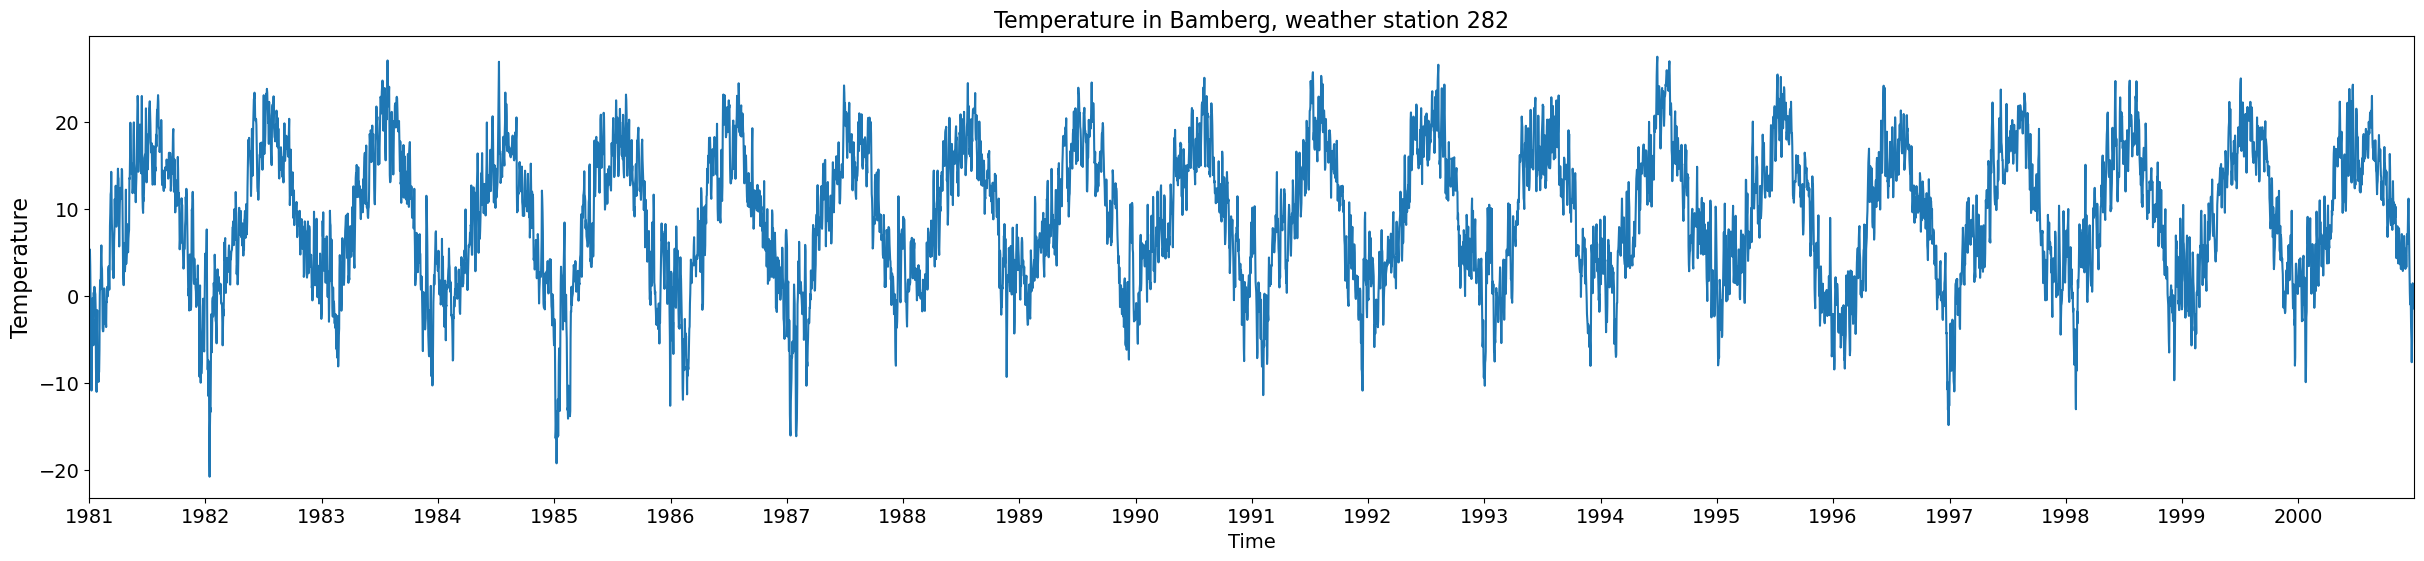

In [6]:
#plot training data
plot(train_df)

## Training Data Preparation

Aggregate values over a given time span. Then, impute missing values using a SimpleImputer. Finally, normalize values to an interval of [-1, 1] using MinMaxScaler.

In [7]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(train_df, interval=86400, time_column='timestamp')

In [8]:
#impute missing values
imp = SimpleImputer()
X = imp.fit_transform(X)

In [9]:
#normalise data
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

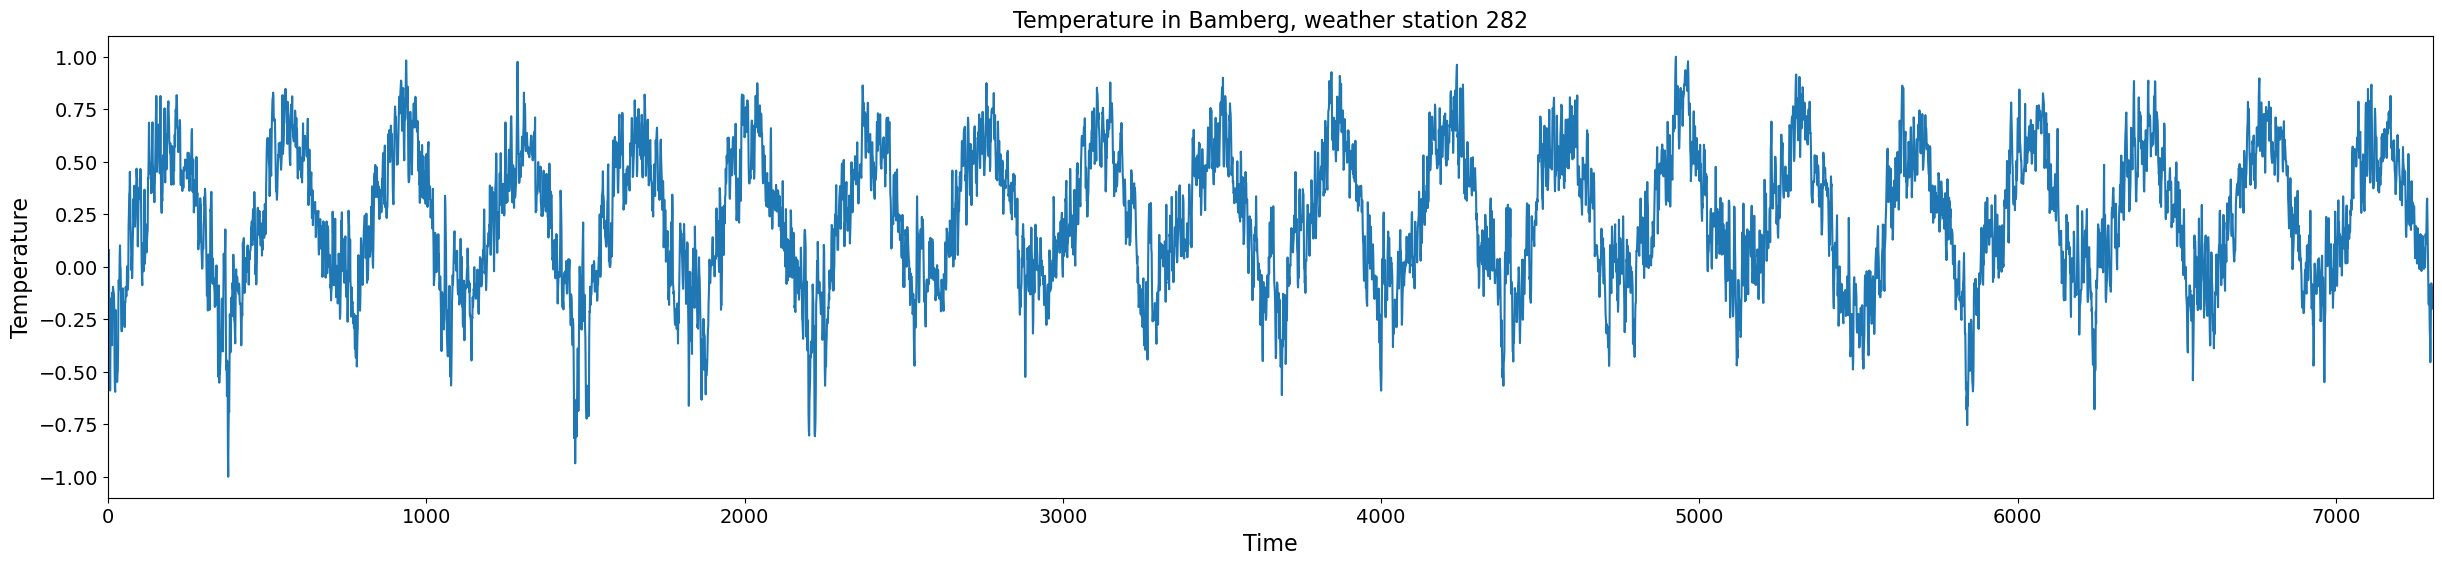

In [10]:
#plotting the processed signal
plot_ts(X)

Slice the data using the rolling window

In [11]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [12]:
#print information about training signal
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (7205, 100, 1)
Training data index shape: (7205,)
Training y shape: (7205, 1)
Training y index shape: (7205,)


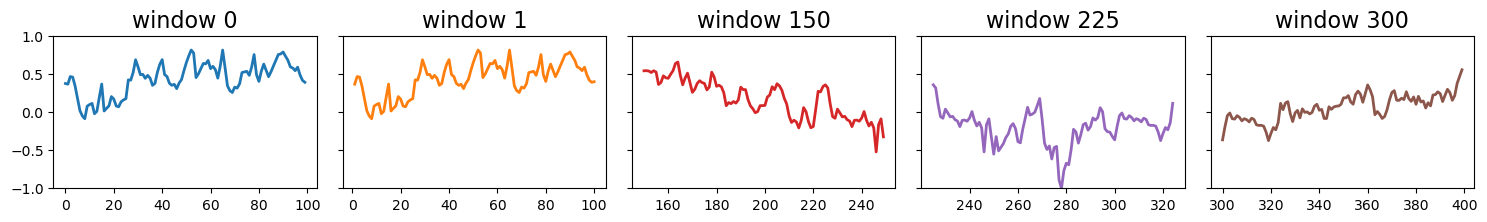

In [13]:
#plot windows
plot_rws(X)

## Training TadGAN 


In [14]:
from model import hyperparameters
from tadgan import TadGAN

In [15]:
hyperparameters["epochs"] = 35
hyperparameters["input_shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

In [16]:
tgan = TadGAN(**hyperparameters)
tgan.fit(X)

Epoch: 1/35, Losses: {'cx_loss': 0.3195, 'cz_loss': -1.3546, 'eg_loss': 0.4477}
Epoch: 2/35, Losses: {'cx_loss': -0.7544, 'cz_loss': -2.9204, 'eg_loss': -8.113}
Epoch: 3/35, Losses: {'cx_loss': -0.7534, 'cz_loss': -3.3647, 'eg_loss': -7.5824}
Epoch: 4/35, Losses: {'cx_loss': -0.562, 'cz_loss': -3.6163, 'eg_loss': -8.8382}
Epoch: 5/35, Losses: {'cx_loss': -0.5728, 'cz_loss': -3.6491, 'eg_loss': -5.1156}
Epoch: 6/35, Losses: {'cx_loss': -0.6044, 'cz_loss': -3.6781, 'eg_loss': -7.0788}
Epoch: 7/35, Losses: {'cx_loss': -0.4808, 'cz_loss': -3.5664, 'eg_loss': -4.4556}
Epoch: 8/35, Losses: {'cx_loss': -0.4859, 'cz_loss': -3.8997, 'eg_loss': -1.3227}
Epoch: 9/35, Losses: {'cx_loss': -0.4517, 'cz_loss': -3.7787, 'eg_loss': -10.8986}
Epoch: 10/35, Losses: {'cx_loss': -0.3886, 'cz_loss': -3.7874, 'eg_loss': -3.2139}
Epoch: 11/35, Losses: {'cx_loss': -0.3645, 'cz_loss': -3.7956, 'eg_loss': -3.4956}
Epoch: 12/35, Losses: {'cx_loss': -0.2826, 'cz_loss': -3.6694, 'eg_loss': -12.4514}
Epoch: 13/35, L

## Test 1: Application

Aggregate values over a given time span. Then, impute missing values using a SimpleImputer. Finally, normalize values to an interval of [-1, 1] using MinMaxScaler.

Using the fitted TadGAN model to reconstruct the time series signal. Then, utilize a combination of the reconstructed error and critic error to define anomaly regions.

In [17]:
X1_test, index1_test = time_segments_aggregate(test1_df, interval=86400, time_column='timestamp')

In [18]:
imp = SimpleImputer()
X1_test = imp.fit_transform(X1_test)
scaler = MinMaxScaler(feature_range=(-1, 1))
X1_test = scaler.fit_transform(X1_test)

In [19]:
X1_test, y1_test, X1_test_index, y1_test_index = rolling_window_sequences(X1_test, index1_test, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [20]:
print("Test1 data input shape: {}".format(X1_test.shape))
print("Test1 data index shape: {}".format(X1_test_index.shape))
print("Test1 y shape: {}".format(y1_test.shape))
print("Test1 y index shape: {}".format(y1_test_index.shape))

Test1 data input shape: (7205, 100, 1)
Test1 data index shape: (7205,)
Test1 y shape: (7205, 1)
Test1 y index shape: (7205,)


226/226 [==============================] - 2s 9ms/step


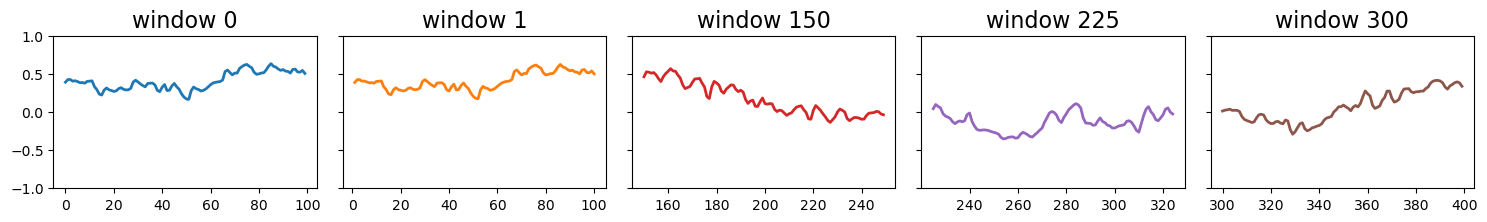

In [21]:
#reconstruct
X1_test_hat, critic = tgan.predict(X1_test)

#visualize X_hat
plot_rws(X1_test_hat)

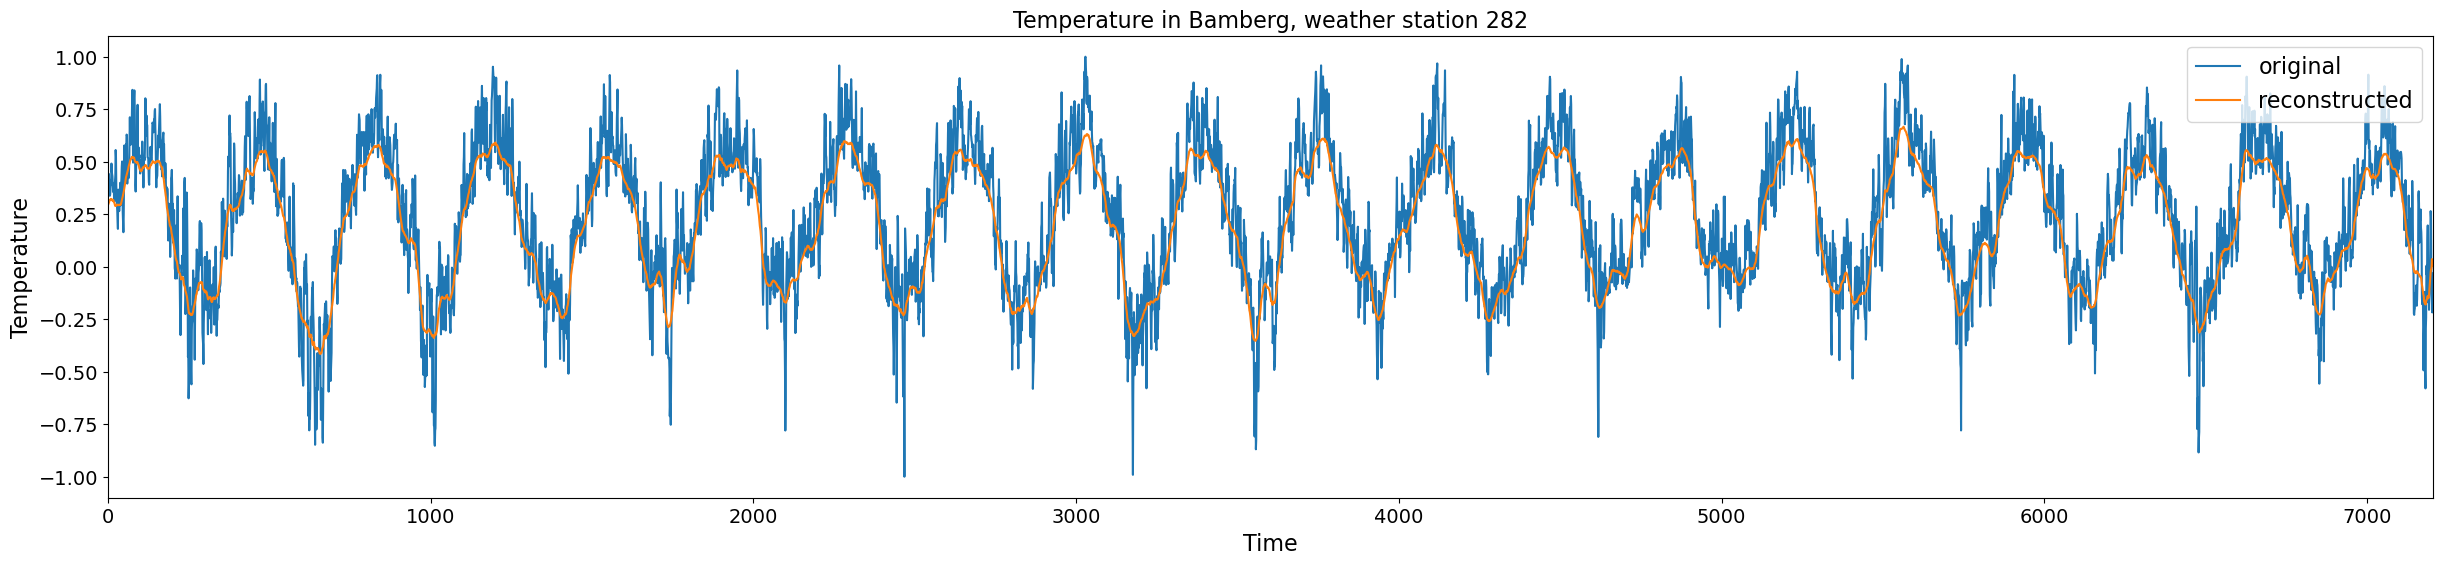

In [22]:
#flatten the predicted windows
y1_test_hat = unroll_ts(X1_test_hat)

#plot the time series
plot_ts([y1_test, y1_test_hat], labels=['original', 'reconstructed'])

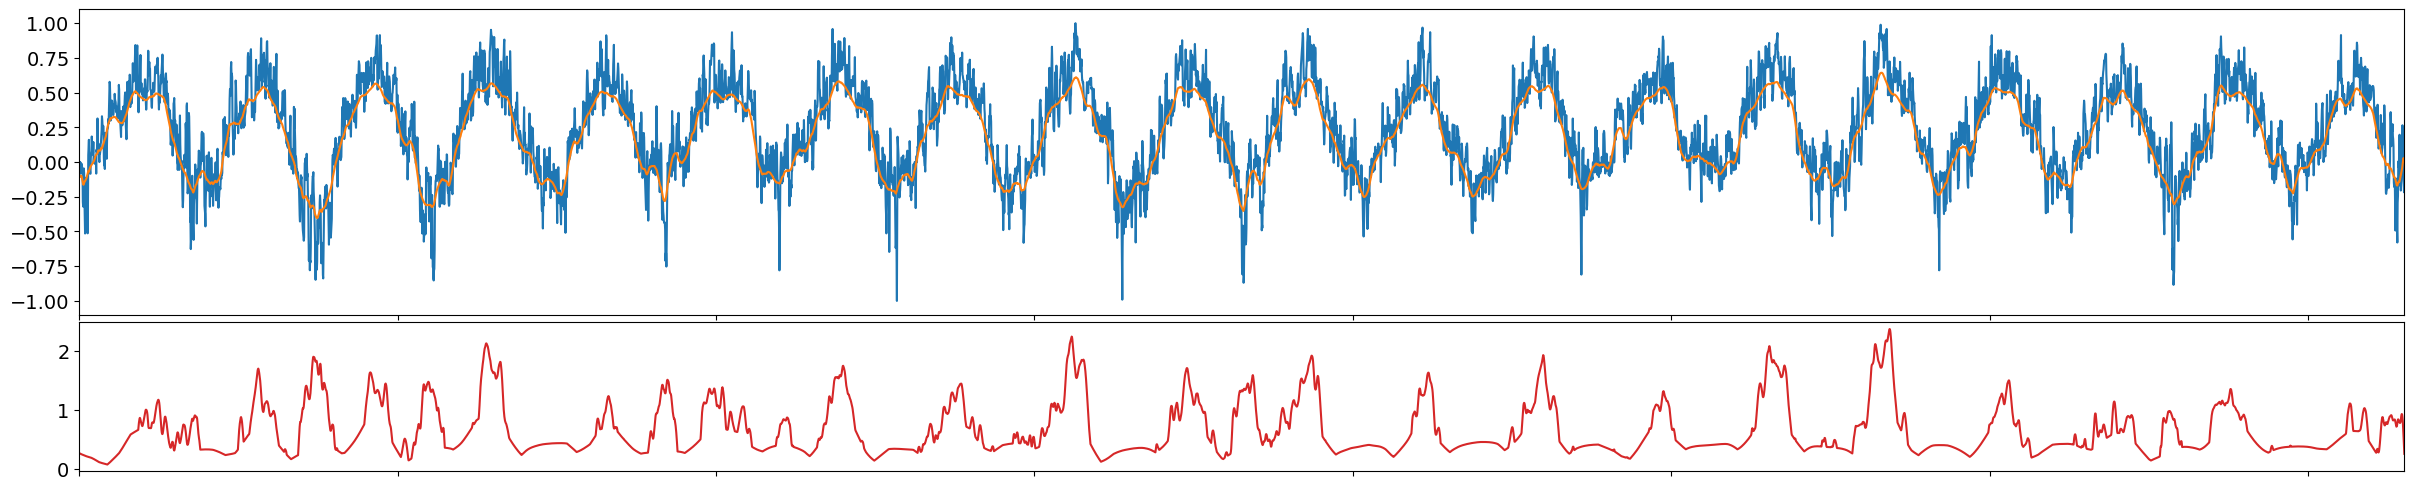

In [25]:
from tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X1_test, X1_test_hat, critic, X1_test_index, rec_error_type="area", comb="sum")
pred = np.array(pred).mean(axis=2)

#visualize the error curve
plot_error([[true, pred], error])

In [26]:
from timeseries_anomalies import find_anomalies

#detect anomaly regions
intervals = find_anomalies(error, index, 
                           window_size_portion=0.005, #was 0.33 in original tutorial
                           window_step_size_portion=0.1, 
                           fixed_threshold=True) 
intervals

array([[3.79638000e+08, 3.82748400e+08, 1.96215238e-02],
       [3.87241200e+08, 3.90351600e+08, 8.61737662e-02],
       [4.03484400e+08, 4.06594800e+08, 3.98597289e-02],
       [4.16271600e+08, 4.19382000e+08, 1.58971746e-02],
       [4.45993200e+08, 4.49103600e+08, 1.10860837e-03],
       [4.98524400e+08, 5.01634800e+08, 4.63416837e-02],
       [5.09238000e+08, 5.12348400e+08, 1.00512802e-01],
       [6.56809200e+08, 6.59919600e+08, 2.44451546e-02],
       [9.08751600e+08, 9.11862000e+08, 4.69108193e-02],
       [9.17737200e+08, 9.20847600e+08, 4.39935539e-02]])

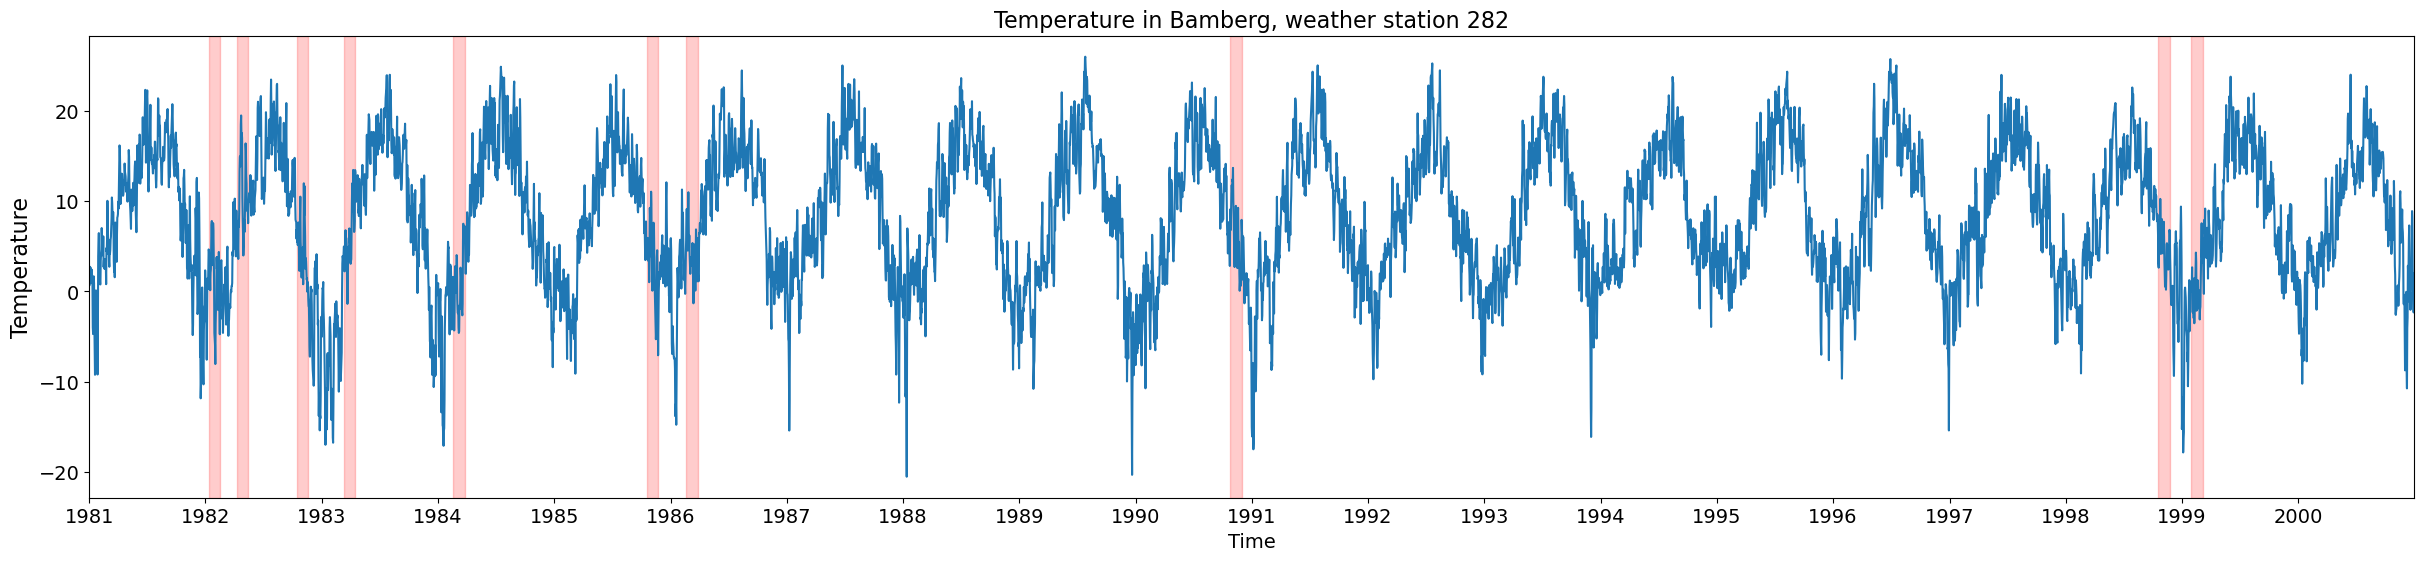

In [27]:
#plot anomaly regions
anomalies_1 = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(test1_df, anomalies_1)

In [36]:
#Create an empty DataFrame to add anomaly regions from each combination of reconstructed errors.
#anomalies_1_full = pd.DataFrame()

In [180]:
#add detected anomalies to summary DataFrame
anomalies_1_full = pd.concat([anomalies_1_full, anomalies_1], ignore_index=True)
anomalies_1_full.head(30)

,start,end,score
0,347497200.0,350607600.0,0.005915
1,351990000.0,355100400.0,0.007757
2,447030000.0,450140400.0,0.037139
3,457052400.0,460162800.0,0.008658
4,474678000.0,477788400.0,0.022128
5,509929200.0,513039600.0,0.052389
6,519606000.0,523062000.0,0.007118
7,540687600.0,543798000.0,0.001133
8,572137200.0,575247600.0,0.001488
9,758415600.0,761526000.0,0.029031


In [181]:
#save summary as .csv file
anomalies_1_full.to_csv('temperature anomalies raw 1.csv')

## Test 2: Application

Aggregate values over a given time span. Then, impute missing values using a SimpleImputer. Finally, normalize values to an interval of [-1, 1] using MinMaxScaler.

Using the fitted TadGAN model to reconstruct the time series signal. Then, utilise a combination of the reconstructed error and critic error to define anomaly regions.

In [28]:
X2_test, index2_test = time_segments_aggregate(test2_df, interval=86400, time_column='timestamp')

In [29]:
imp = SimpleImputer()
X2_test = imp.fit_transform(X2_test)
scaler = MinMaxScaler(feature_range=(-1, 1))
X2_test = scaler.fit_transform(X2_test)

In [30]:
X2_test, y2_test, X2_test_index, y2_test_index = rolling_window_sequences(X2_test, index2_test, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [31]:
print("Test2 data input shape: {}".format(X2_test.shape))
print("Test2 data index shape: {}".format(X2_test_index.shape))
print("Test2 y shape: {}".format(y2_test.shape))
print("Test2 y index shape: {}".format(y2_test_index.shape))

Test2 data input shape: (7202, 100, 1)
Test2 data index shape: (7202,)
Test2 y shape: (7202, 1)
Test2 y index shape: (7202,)


226/226 [==============================] - 2s 9ms/step


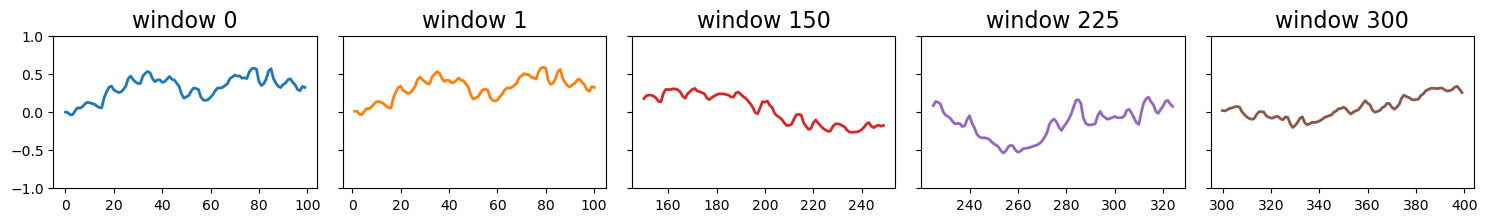

In [32]:
#reconstruct
X2_test_hat, critic = tgan.predict(X2_test)

#visualize X_hat
plot_rws(X2_test_hat)

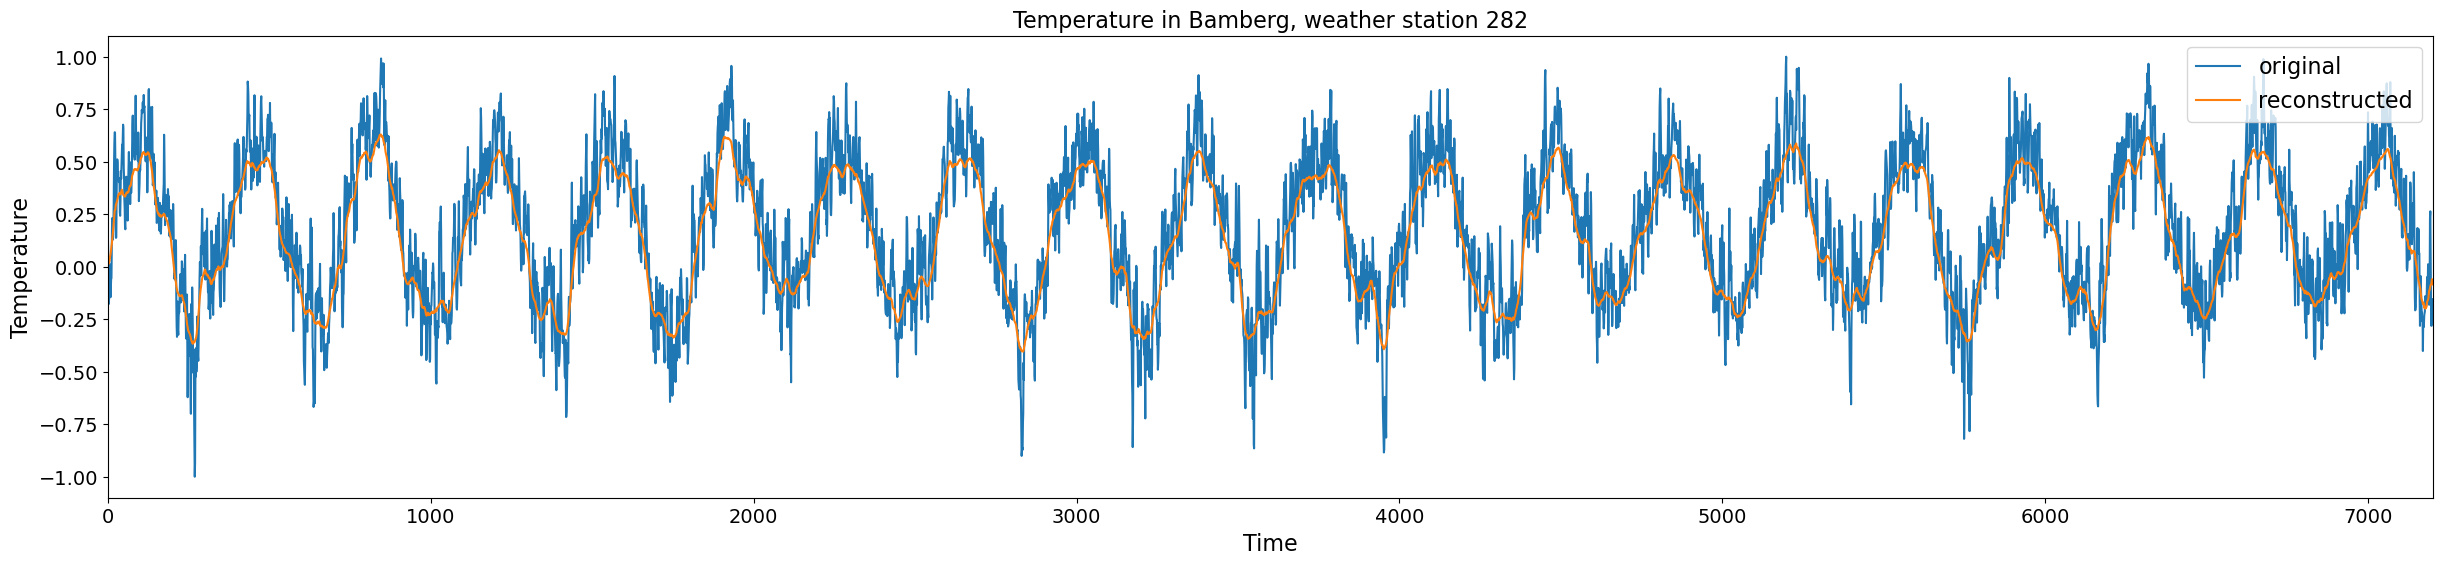

In [33]:
#flatten the predicted windows
y2_test_hat = unroll_ts(X2_test_hat)

#plot the time series
plot_ts([y2_test, y2_test_hat], labels=['original', 'reconstructed'])

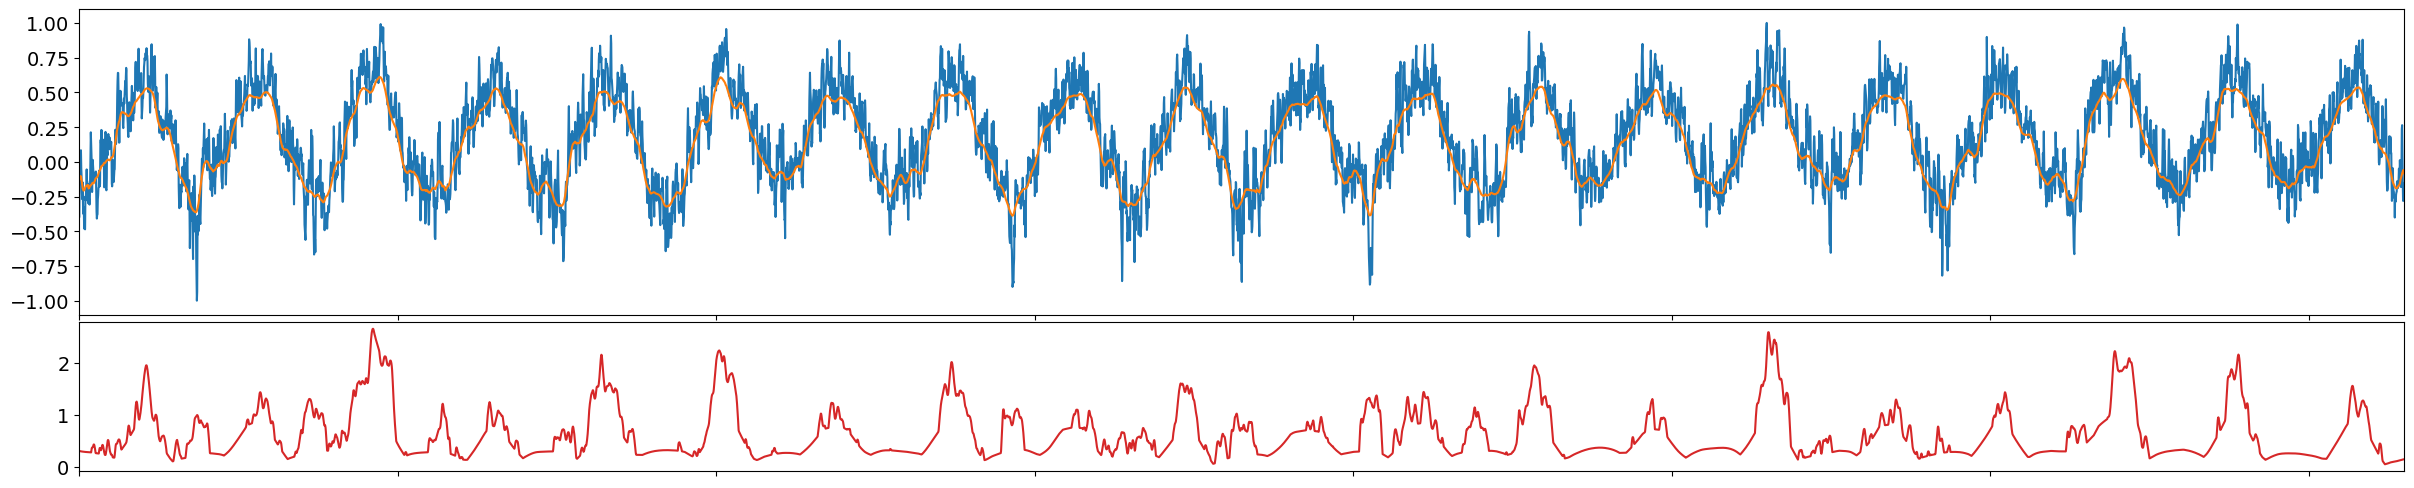

In [36]:
from tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X2_test, X2_test_hat, critic, X2_test_index, rec_error_type="area", comb="sum")
pred = np.array(pred).mean(axis=2)

#visualize the error curve
plot_error([[true, pred], error])

In [37]:
from timeseries_anomalies import find_anomalies

#find anomalies
intervals = find_anomalies(error, index2_test, 
                           window_size_portion=0.005, #was 0.33
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals

array([[1.01355480e+09, 1.01666520e+09, 1.46130762e-01],
       [1.05399000e+09, 1.05710040e+09, 6.97998707e-04],
       [1.06988760e+09, 1.07299800e+09, 1.16065114e-01],
       [1.10375640e+09, 1.10686680e+09, 4.70844464e-02],
       [1.12898520e+09, 1.13209560e+09, 7.08401320e-02],
       [1.13762520e+09, 1.14073560e+09, 6.01026346e-02],
       [1.16700120e+09, 1.17011160e+09, 3.00747213e-02],
       [1.22540760e+09, 1.22851800e+09, 1.87728482e-01],
       [1.23439320e+09, 1.23750360e+09, 1.46508785e-02],
       [1.29763800e+09, 1.30074840e+09, 2.47754314e-02],
       [1.32252120e+09, 1.32563160e+09, 1.92772227e-01],
       [1.33150680e+09, 1.33461720e+09, 6.76548212e-02],
       [1.36053720e+09, 1.36364760e+09, 6.15976779e-02],
       [1.45350360e+09, 1.45661400e+09, 2.50383803e-02],
       [1.47907800e+09, 1.48218840e+09, 4.24269008e-03],
       [1.48564440e+09, 1.48875480e+09, 3.88528276e-02],
       [1.51432920e+09, 1.51743960e+09, 1.10524062e-01],
       [1.60280280e+09, 1.60591

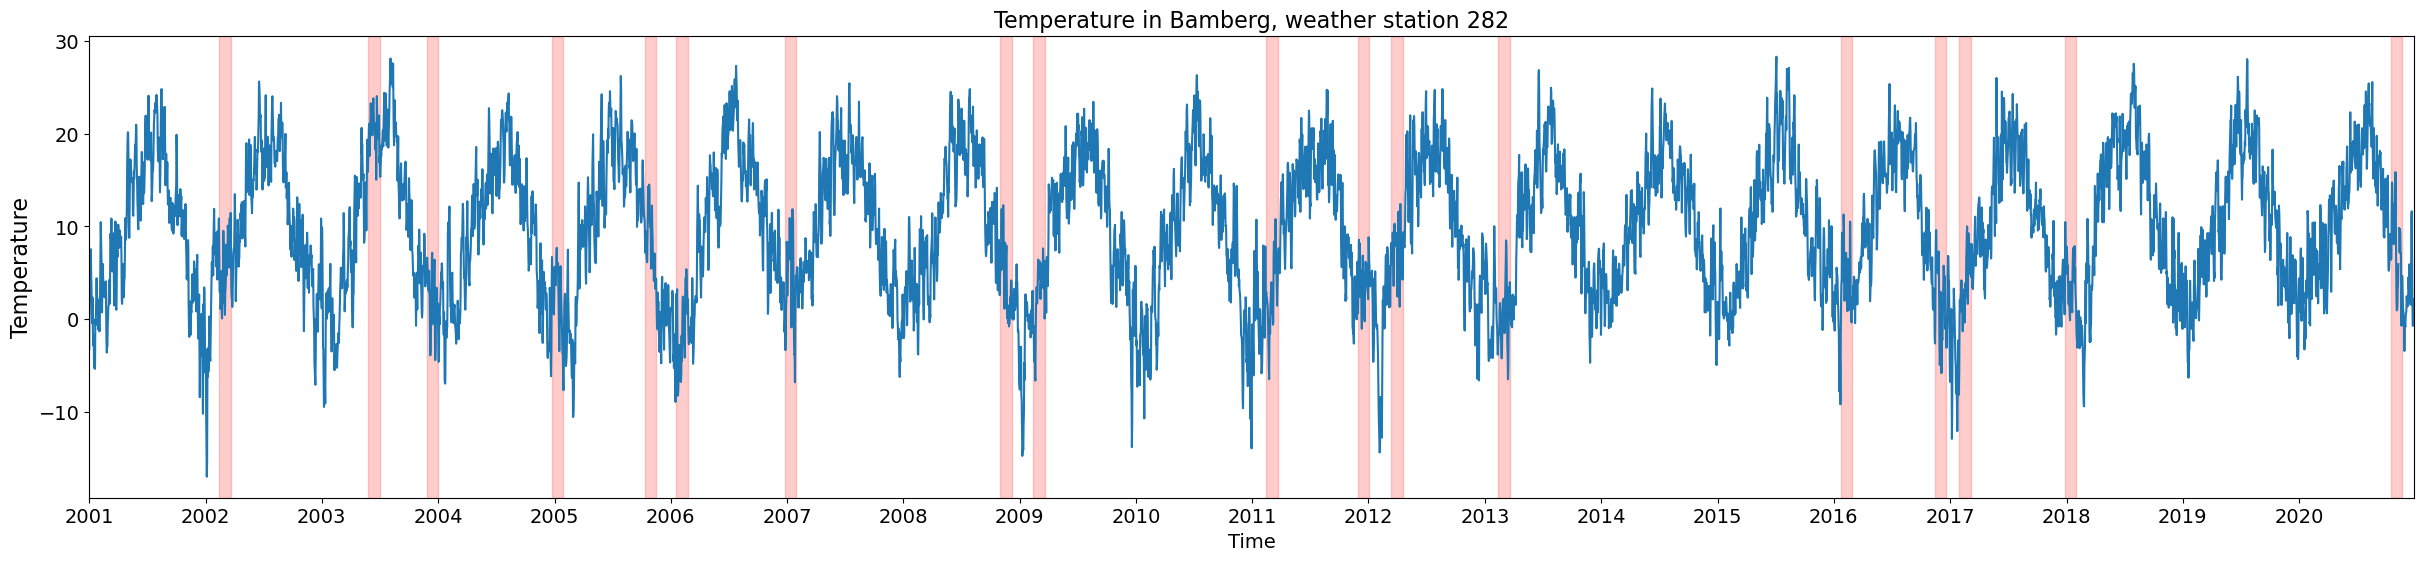

In [38]:
#plot anomaly regions
anomalies_2 = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(test2_df, anomalies_2)

In [51]:
#Create an empty DataFrame to add anomaly regions from each combination of reconstructed errors.
#anomalies_2_full = pd.DataFrame()

In [52]:
#add detected anomalies to summary DataFrame
anomalies_2_full = pd.concat([anomalies_2_full, anomalies_2], ignore_index=True)
anomalies_2_full.head(30)

,start,end,score
0,9.796860e+08,9.834876e+08,0.005226
1,1.068851e+09,1.071961e+09,0.004312
2,1.087859e+09,1.090969e+09,0.006089
3,1.095808e+09,1.098918e+09,0.066051
4,1.173222e+09,1.176332e+09,0.147759
5,1.183590e+09,1.186700e+09,0.010478
6,1.216422e+09,1.219532e+09,0.023227
7,1.255129e+09,1.258240e+09,0.071431
8,1.322176e+09,1.325286e+09,0.026687
9,1.380582e+09,1.383692e+09,0.069390


In [53]:
#save summary as .csv file
anomalies_2_full.to_csv('temperature anomalies raw 2.csv')